In [1]:
# notebook dedicated to computing various intrinsic metrics to see whether 
# they corresond to downstream performance and could be useful for RLHF

In [2]:
from transformers import AutoTokenizer
import pandas as pd
from rlhfutils.eval_utils import getapfsft, tok_dist
import matplotlib.pyplot as plt
from rlhfutils.debug_utils import load_rm, progress_rm, load_all_rmdfs, load_all_hackdfs, highlight_differences
from statistics import mean, stdev, median
from scipy.stats import pearsonr, kendalltau, spearmanr
import math
from rouge_score import rouge_scorer

/home/prasann/miniconda3/envs/rlenv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2023-09-08 14:36:38,899] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [3]:
%load_ext autoreload
%autoreload 2

In [11]:
# replace all wgptouts with corresponding stack QA format (RM input format)
def setall(l):
    newl = []
    try:
        for ind in l:
            newl.append(getapfsft(ind, True))
            #print(0)
    except:
        return None
    return newl

def splitall(l):
    try: 
        return [s.split("Answer:")[1] for s in l]
    except:
        return None

def getfulldist(lcol):
    hist = []
    for l in lcol:
        hist.extend(l)
    return hist

def compdist(lcol, slen):
    res = []
    tmp = []
    for i in range(len(lcol)):
        tmp.append(lcol[i])
        if len(tmp)%slen==0:
            res.append(tmp)
            tmp = []
    return res
    
def procall(indf, toker, needset=True):
    if needset:
        indf['response'] = [setall(s) for s in indf['response']]
    indf = indf.dropna()
    indf['answers'] = [splitall(s) for s in indf['response']]
    indf = indf.dropna()
    indf['atoks'] = [tok_dist(s, wgtok) for s in list(indf['answers'])]
    indf['ttoks'] = [tok_dist(s, wgtok) for s in list(indf['response'])]
    return indf

# take rouge between all pairs. High rouge should bigger gaps
def rpaircorr(row, scat=False):
    rouges = []
    diffs = []
    for i in range(len(row)):
        for j in range(i, len(row)):
            if i==j:
                continue
            trmp = scorer.score(row['answers'][i], row['answers'][j])
            rouges.append(trmp['rouge1'].fmeasure)
            diffs.append(math.pow(row['reward'][i]-row['reward'][j], 2))
    if scat:
        return rouges, diffs
    return pearsonr(rouges, diffs).statistic

In [5]:
x, y = rpaircorr(rmdfs['stack_rewardmixed'].loc[0], True)
plt.scatter(x, y)

NameError: name 'rmdfs' is not defined

In [25]:
scorer = rouge_scorer.RougeScorer(['rouge1'], use_stemmer=True)

INFO:absl:Using default tokenizer.


In [22]:
scorer.score("Hi there", "Hi there bob.")

{'rouge1': Score(precision=0.6666666666666666, recall=1.0, fmeasure=0.8),
 'rougeL': Score(precision=0.6666666666666666, recall=1.0, fmeasure=0.8)}

In [12]:
stacktok = AutoTokenizer.from_pretrained("../stack-llama/models/sft/")
wgtok = AutoTokenizer.from_pretrained("../webgpt-llama/models/sft10k/")

In [ ]:
tok, stackorigrm, kwargs = load_rm("../stack-llama/models/rewardbigdset/", 0)

In [21]:
shuffdfs = load_all_rmdfs("../trl-general/rmshuffs/")
rmdfs = load_all_rmdfs("../trl-general/rmouts/")
moredfs = load_all_rmdfs("../trl-general/morermouts/")

In [7]:
attdfs = load_all_hackdfs("../trl-general/fullattacks/")

In [9]:
rmdfs.keys()

dict_keys(['stack_rewardmixed', 'wgpt_rewardmodel', 'wgpt_rewardrandda', 'stack_rewardda', 'wgpt_lenbalance', 'stack_rewardsanity', 'stack_rewardrandaug'])

In [8]:
ind = 10
r = attdfs['wgptda'].iloc[ind]
highlight_differences(r['origseq'], r['bestseqs'][-1])

In [9]:
kmap = {
    'stackrandaug':'stack_rewardrandaug',
    'stackda':'stack_rewardda',
    'stackmix':'stack_rewardmixed',
    'wgptda':'wgpt_rewardrandda',
    'wgptorig':'wgpt_rewardmodel',
    'stacksanity':'stack_rewardsanity'
}

In [18]:
rmdfs.keys()

dict_keys(['stack_shuffrewardda', 'stack_shuffrewardmixed', 'wgpt_shuffrewardmodel', 'wgpt_shuffrewardrandda', 'stack_shuffrewardsanity', 'stack_shuffrewardrandaug'])

In [8]:
keyval = "wgpt_rewardmodel"

In [15]:
def getcorr(row, pearson=False):
    if pearson:
        return pearsonr(row['atoks'], row['reward']).statistic
    else:
        return kendalltau(row['atoks'], row['reward']).statistic

In [16]:
for k in attdfs.keys():
    norm = stdev(getfulldist(rmdfs[kmap[k]].reward))
    print(k)
    # print(attdfs[k]['diff'].mean())
    print(norm)

NameError: name 'kmap' is not defined

In [18]:
for k in shuffdfs.keys():
    tmpa = pd.DataFrame({
        'or':getfulldist(rmdfs[k.replace("shuff", "")].reward),
        'shuff':getfulldist(shuffdfs[k].reward),
    })
    norm = stdev(list(tmpa['or']))
    print(k)
    # print((tmpa['or']-tmpa['shuff']).abs().mean()/norm)
    print(norm)
    #print(spearmanr(getfulldist(rmdfs[keyval].reward), getfulldist(rmdfs[keyval].atoks)))
    #print(kendalltau(getfulldist(rmdfs[keyval].reward), getfulldist(rmdfs[keyval].atoks)))v

stack_shuffrewardrandaug
1.144137052695234
stack_shuffrewardsanity
0.7120275705076311
stack_shuffrewardmixed
0.9171077907658536
wgpt_shuffrewardmodel
0.512840646944082
wgpt_shuffrewardrandda
0.35258641598335
stack_shuffrewardda
0.9241051543405661


In [22]:
rmdfs = moredfs

In [23]:
for k in rmdfs.keys():
    print(k)
    keyval = k
    sps = [getcorr(r, True) for _, r in rmdfs[k].iterrows()]
    kts = [getcorr(r, False) for _, r in rmdfs[k].iterrows()]
    print(mean([s for s in sps if not math.isnan(s)]))
    print(mean([s for s in kts if not math.isnan(s)]))
    #print(spearmanr(getfulldist(rmdfs[keyval].reward), getfulldist(rmdfs[keyval].atoks)))
    #print(kendalltau(getfulldist(rmdfs[keyval].reward), getfulldist(rmdfs[keyval].atoks)))v

wgpt_rewardmixwgpt


/home/prasann/miniconda3/envs/rlenv/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


0.6925626213012205
0.538645599501303
wgpt_lenbalance
0.6292748557910091
0.47881590073407937


In [28]:
for k in rmdfs.keys():
    print(k)
    keyval = k
    norm = stdev(getfulldist(rmdfs[k].reward))
    results = [(max(s)-median(s))/norm for s in rmdfs[k].reward]
    #results = [rpaircorr(r) for _, r in rmdfs[k].iterrows()]
    print(mean([r for r in results if not math.isnan(r)]))


wgpt_rewardmixwgpt
0.869603237446364
wgpt_lenbalance
0.7697249795355862


(array([  94.,  482., 1565., 1944., 1199.,  667.,  252.,  103.,   47.,
          39.]),
 array([  2. ,  27.6,  53.2,  78.8, 104.4, 130. , 155.6, 181.2, 206.8,
        232.4, 258. ]),
 <BarContainer object of 10 artists>)

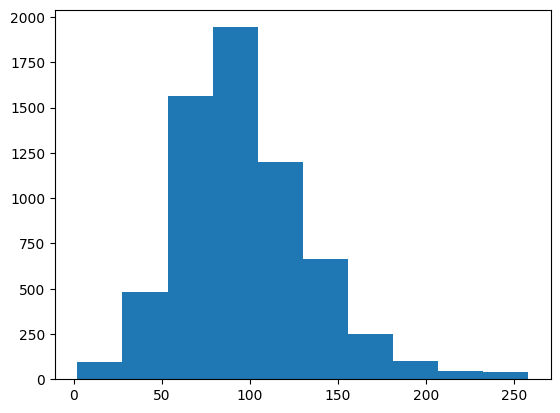

In [91]:
plt.hist(getfulldist(rmdfs[keyval].atoks))

In [19]:
for k in rmdfs.keys():
    print(k)
    keyval = k
    print(pearsonr(getfulldist(rmdfs[keyval].reward), getfulldist(rmdfs[keyval].atoks)))
    #print(spearmanr(getfulldist(rmdfs[keyval].reward), getfulldist(rmdfs[keyval].atoks)))
    # print(kendalltau(getfulldist(rmdfs[keyval].reward), getfulldist(rmdfs[keyval].atoks)))

stack_shuffrewardda
PearsonRResult(statistic=0.19360208722151298, pvalue=9.304967998824017e-55)
stack_shuffrewardmixed
PearsonRResult(statistic=-0.02117794872229203, pvalue=0.0912595806538025)
wgpt_shuffrewardmodel
PearsonRResult(statistic=0.6862010148602476, pvalue=0.0)
wgpt_shuffrewardrandda
PearsonRResult(statistic=0.24138648827280548, pvalue=2.0606832492580663e-85)
stack_shuffrewardsanity
PearsonRResult(statistic=0.09725125541677739, pvalue=7.685828382720676e-15)
stack_shuffrewardrandaug
PearsonRResult(statistic=0.07587236737730434, pvalue=1.3753695111232166e-09)


In [ ]:
rmdfs = load_all_rmdfs("../trl-general/fullattacks/")

In [ ]:
print(mean([stdev(s) for s in rmdfs[keyval].reward])/stdev(getfulldist(rmdfs[keyval].reward)))
plt.hist([stdev(s) for s in rmdfs[keyval].reward])

In [ ]:
wgptorigrm = load_rm("../tr")

In [11]:
allresps = getfulldist(stackouts.response)

In [16]:
allscos = progress_rm(allresps[:100], stackorigrm, kwargs)

 57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 4/7 [00:32<00:27,  9.12s/it]/home/prasann/miniconda3/envs/rlenv/lib/python3.9/site-packages/transformers/pipelines/base.py:1083: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:49<00:00,  7.09s/it]


In [ ]:
compdist([a[0]['score'] for a in allscos], 8)

(array([ 229.,  526.,  818.,  767.,  656.,  560.,  466.,  340.,  289.,
        1709.]),
 array([  4. ,  30.2,  56.4,  82.6, 108.8, 135. , 161.2, 187.4, 213.6,
        239.8, 266. ]),
 <BarContainer object of 10 artists>)

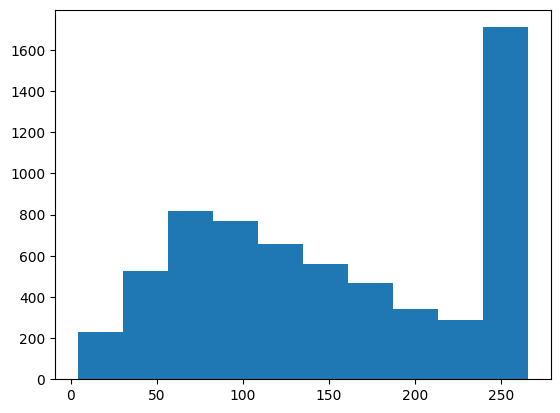

In [8]:
plt.hist(getfulldist(stackouts.atoks))